 # <center> <strong> Kaggle: Predicting a Biological Response

### Вводные данные
Наша практика будет основана на соревновании Kaggle: Predicting a Biological Response (Прогнозирование биологического ответа). Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV. Каждая строка представляет молекулу.

* Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1];
* Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.
Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

Загружаем все необходимые библиотеки для дальнейшей работы

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
from sklearn import model_selection
import optuna



Записываем датасет в переменную data

In [2]:
data=pd.read_csv('_train_sem09__1_.zip')

Выведем на экран 5 строк из нашего датасета, что бы посмотреть из чего состоит он

In [3]:
data.head(5)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


В задаче указано, что данные подготовленные, но для уверенности смотрим нет ли  пропусков в данных

In [4]:
data.isna().sum().sum()

0

И дубликатов

In [5]:
data.duplicated().sum()

0

Записываем в переменные X и y нашу матрицу наблюдений и целевой признак

In [6]:
X=data.drop(['Activity'],axis=1)
y=data['Activity']

Разделим данные на тренировочные и тестовые

In [7]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

При этом не будем стратифицировать их, т.к. далее мы будем использовать это при оценке нашей модели. Рассмотрим распределение в целевом признаке

In [8]:
y_train.value_counts(normalize=True)

1    0.533667
0    0.466333
Name: Activity, dtype: float64

In [9]:
y_test.value_counts(normalize=True)

1    0.576565
0    0.423435
Name: Activity, dtype: float64

Данные почти одинаково распределены. И миноритальный класс в обоих выборках распределен почти идентично

### 1.1  Подбор лучших гиперпараметров с помощью GridSearch для модели LogisticRegression

Введем наши переменные для дальнейшей работы, KFOLD стратификацию и параметры для поиска лучших из них, отдельно для LogisticRegression и для RandomForest

In [10]:
cvs=StratifiedKFold(n_splits=5)

In [11]:
params_lr=[{'penalty':['l1','l2'],
        'solver':['liblinear','saga'],
        'C':list(np.arange(0,1.1,0.25))},
        {'penalty':['l2',None],
        'solver':['lbfgs','sag'],
        'C':list(np.arange(0,1.1,0.25))}]
params_rf={'n_estimators':list(range(100,401,100)),
        'criterion':['entropy','gini'],
        'max_depth':[3,5,7],
        'min_samples_leaf':[3,5,7]}

Запустим нашу функцию GridSearch и выясним, какое время занимает поиск лучших параметров

In [ ]:
model_logic_GSCV=LogisticRegression(random_state=42,max_iter=200)
GridSearch_lr=GridSearchCV(estimator=model_logic_GSCV,
             param_grid=params_lr,
             n_jobs=-1,
             scoring='f1',
             cv=cvs)
%time GridSearch_lr.fit(X_train,y_train)

Данная функция, путем перебора всех вариантов, которые мы ей предложили справилась за 7 минут 19 секунд

Далее выведем на экран лучшие параметры, которая функция предложила и подставим их в модель LogisticRegression

In [13]:
print('Параметры, полученные с помощью GridSearch для логистической регрессии')
print()
print('Лучшие параметры:{}'.format(GridSearch_lr.best_params_))
print('f1-score для валидационной выборки: {}'.format(GridSearch_lr.best_score_.round(3)))

Параметры, полученные с помощью GridSearch для логистической регрессии

Лучшие параметры:{'C': 0.75, 'penalty': 'l1', 'solver': 'liblinear'}
f1-score для валидационной выборки: 0.784


In [14]:
C=GridSearch_lr.best_params_['C']
penalty=GridSearch_lr.best_params_['penalty']
solver=GridSearch_lr.best_params_['solver']

In [15]:
model_logic=LogisticRegression(C=C,penalty=penalty,solver=solver,random_state=42,max_iter=200)
model_logic.fit(X_train,y_train)
predict_logic_y_train=model_logic.predict(X_train)
predict_logic_y_test=model_logic.predict(X_test)
print('Результат, полученный подбором гиперпараметров для логистической регрессии, с помощью GridSearch')
print()
print('Метрика F1-score на тренировочных данных равна:{}'.format((metrics.f1_score(y_train,predict_logic_y_train)).round(3)))
print('Метрика F1-score на тестовых данных равна:{}'.format(metrics.f1_score(y_test,predict_logic_y_test).round(3)))

Результат, полученный подбором гиперпараметров для логистической регрессии, с помощью GridSearch

Метрика F1-score на тренировочных данных равна:0.866
Метрика F1-score на тестовых данных равна:0.789


Будем в дальнейшем сравивать время обучения функций поиска гиперпараметров между собой,сами гиперпараметры и результат

### 1.2 Подбор лучших гиперпараметров с помощью GridSearch для модели RandomForest

Проделаем тоже самое для модели RandomForest

In [16]:
model_Random_Forest_GSCV=RandomForestClassifier(random_state=42)

GridSearch_rf=GridSearchCV(estimator=model_Random_Forest_GSCV,
             param_grid=params_rf,
             n_jobs=-1,
             scoring='f1',
             cv=cvs
)

%time GridSearch_rf.fit(X_train,y_train)

CPU times: user 3.94 s, sys: 149 ms, total: 4.09 s
Wall time: 3min 21s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [3, 5, 7],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='f1')

3 минуты 21 секунда, нашей функции GridSearch понадобилось, что бы справится с поиском лучших гиперпараметров для модели RandomForest.Выводим лучший вариант и подставляем их в модель, далее смотрим метрику f1 уже с подобранными гиперпараметрами.

In [17]:
print('Параметры, полученные с помощью GridSearch для случайного леса')
print()
print('Лучшие параметры для случайного леса:{}'.format(GridSearch_rf.best_params_))
print('f-score для валидационной выборки: {}'.format(GridSearch_rf.best_score_.round(3)))

Параметры, полученные с помощью GridSearch для случайного леса

Лучшие параметры для случайного леса:{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 3, 'n_estimators': 300}
f-score для валидационной выборки: 0.786


In [18]:
criterion=GridSearch_rf.best_params_['criterion']
max_depth=GridSearch_rf.best_params_['max_depth']
min_samples_leaf=GridSearch_rf.best_params_['min_samples_leaf']
n_estimators=GridSearch_rf.best_params_['n_estimators']

In [19]:
model_Random_Forest=RandomForestClassifier(criterion=criterion,max_depth=max_depth,min_samples_leaf=min_samples_leaf,n_estimators=n_estimators,random_state=42)

model_Random_Forest.fit(X_train,y_train)

predict_RF_y_train=model_Random_Forest.predict(X_train)
predict_RF_y_test=model_Random_Forest.predict(X_test)

print('Результат, полученный подбором гиперпараметров для случайного леса, с помощью GridSearch')
print()
print('Метрика F1-score на тренировочных данных равна:{}'.format((metrics.f1_score(y_train,predict_RF_y_train)).round(3)))
print('Метрика F1-score на тестовых данных равна:{}'.format(metrics.f1_score(y_test,predict_RF_y_test).round(3)))


Результат, полученный подбором гиперпараметров для случайного леса, с помощью GridSearch

Метрика F1-score на тренировочных данных равна:0.858
Метрика F1-score на тестовых данных равна:0.802


Данная модель более точно предсказала целевой признак на тестовых данных(0.802 против 0.789), но эта разница не значительная. Но все же есть. И в два раза быстрее

### 2.1 Подбор лучших гиперпараметров с помощью RandomizeSearch для LogisticRegression

Так же, используя все теже самые гиперпараметры будем искать лучшие с помощью функции поиска RandomizeSearch

In [ ]:
model_logic_RSCV=LogisticRegression(random_state=42,max_iter=200)
RandomizedSearch_lr=RandomizedSearchCV(estimator=model_logic_RSCV,
                                       param_distributions=params_lr,
                                       scoring='f1',
                                       n_jobs=-1,
                                       n_iter=10)
%time RandomizedSearch_lr.fit(X_train,y_train)

Данная модель справляется с задачей за 3 минуты 2 секунды. Что намного быстрее чем модель, которую мы использовали ранее. Выводим на экран результат, далее подставляем их в нашу модель LogisticRegression

In [21]:
print('Параметры, полученные с помощью RandomizeSearch для логистической регрессии')
print()
print('Лучшие параметры для логистической регрессии:{}'.format(RandomizedSearch_lr.best_params_))
print('f-score для валидационной выборки: {}'.format(RandomizedSearch_lr.best_score_.round(3)))

Параметры, полученные с помощью RandomizeSearch для логистической регрессии

Лучшие параметры для логистической регрессии:{'solver': 'saga', 'penalty': 'l1', 'C': 0.75}
f-score для валидационной выборки: 0.782


Но данная модель посчитала, что лучше будет использовать гиперпараметр solver ни 'liblinear', а  'saga'. Хотя если верить рекомендациям использования данного параметра 'liblinear' данный выбор хорош для небольших датасетов.

In [22]:
C=RandomizedSearch_lr.best_params_['C']
penalty=RandomizedSearch_lr.best_params_['penalty']
solver=RandomizedSearch_lr.best_params_['solver']

Подставим наши гиперпараметры в модель и посмотрим метрику на тестовых данных.Сравним, смогли ли мы засчет скорости не потерять качество модели.

In [23]:
model_logic=LogisticRegression(C=C,penalty=penalty,solver=solver,random_state=42,max_iter=200)
model_logic.fit(X_train,y_train)
predict_logic_y_train=model_logic.predict(X_train)
predict_logic_y_test=model_logic.predict(X_test)
print('Результат, полученный подбором гиперпараметров для логистической регрессии, с помощью RandomizeSearch')
print()
print('Метрика F1-score на тренировочных данных равна:{}'.format((metrics.f1_score(y_train,predict_logic_y_train)).round(3)))
print('Метрика F1-score на тестовых данных равна:{}'.format(metrics.f1_score(y_test,predict_logic_y_test).round(3)))

Результат, полученный подбором гиперпараметров для логистической регрессии, с помощью RandomizeSearch

Метрика F1-score на тренировочных данных равна:0.862
Метрика F1-score на тестовых данных равна:0.794


/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Мы видим, что при уменьшении времени в два раза мы не потеряли качество модели, а даже ее улучшили немного. Тем самым модель чуть лучше нашала предугадывать класс.

### 2.2 Подбор лучших гиперпараметров с помощью RandomizeSearch для RandomForest

Проверим, так же это работает при использовании модели RandomForest?

In [24]:
model_Random_Forest_RSCV=RandomForestClassifier(random_state=42)

RandomizedSearch_rf=RandomizedSearchCV(estimator=model_Random_Forest_RSCV,
             param_distributions=params_rf,
             n_jobs=-1,
             scoring='f1',
             cv=cvs
)

%time RandomizedSearch_rf.fit(X_train,y_train)

CPU times: user 1.25 s, sys: 151 ms, total: 1.4 s
Wall time: 36.5 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 7],
                                        'min_samples_leaf': [3, 5, 7],
                                        'n_estimators': [100, 200, 300, 400]},
                   scoring='f1')

Модель справилась за секунды(36), что почти в три раза быстрее чем модель, которая перебирает все варианты гиперпараметов.

In [25]:
print('Параметры, полученные с помощью RandomizeSearch для случайного леса')
print()
print('Лучшие параметры для случайного леса:{}'.format(RandomizedSearch_rf.best_params_))
print('f-score для валидационной выборки: {}'.format(RandomizedSearch_rf.best_score_.round(3)))

Параметры, полученные с помощью RandomizeSearch для случайного леса

Лучшие параметры для случайного леса:{'n_estimators': 100, 'min_samples_leaf': 3, 'max_depth': 7, 'criterion': 'gini'}
f-score для валидационной выборки: 0.784


In [26]:
criterion=RandomizedSearch_rf.best_params_['criterion']
max_depth=RandomizedSearch_rf.best_params_['max_depth']
min_samples_leaf=RandomizedSearch_rf.best_params_['min_samples_leaf']
n_estimators=RandomizedSearch_rf.best_params_['n_estimators']

Подставим наши данные в модель и узнаем результат.

In [27]:
model_Random_Forest=RandomForestClassifier(criterion=criterion,max_depth=max_depth,min_samples_leaf=min_samples_leaf,n_estimators=n_estimators,random_state=42)

model_Random_Forest.fit(X_train,y_train)

predict_RF_y_train=model_Random_Forest.predict(X_train)
predict_RF_y_test=model_Random_Forest.predict(X_test)

print('Результат, полученный подбором гиперпараметров для случайного леса, с помощью RandomizeSearch')
print()
print('Метрика F1-score на тренировочных данных равна:{}'.format((metrics.f1_score(y_train,predict_RF_y_train)).round(3)))
print('Метрика F1-score на тестовых данных равна:{}'.format(metrics.f1_score(y_test,predict_RF_y_test).round(3)))

Результат, полученный подбором гиперпараметров для случайного леса, с помощью RandomizeSearch

Метрика F1-score на тренировочных данных равна:0.851
Метрика F1-score на тестовых данных равна:0.805


Данная модель поиска гиперпараметров переплюнула результат, который был ранее, не особо много, но время обучения поиска гиперпараметров зато при этом мы снизили почти в три раза, что не может не радовать.

### 3.1 Подбор лучших гиперпараметров с помощью Tree-Structured Parzen Estimators (TPE) для LogisticRegression 

Итак дошли до более сложных моделей подбора гиперпараметров. Для начало нам надо задать словарь всех вариантов наших гиперпараметров для модели и написать функцию, которая будет возвращать метрику, но т.к. данная функция поиска гиперпараметров основана на минимизации, то нам надо поставить знак минус перед метрикой.

In [28]:
params_lr_TPE={'penalty':hp.choice('penalty',['l1','l2']),
            'solver':hp.choice(label='solver',options=['liblinear','saga']),
            'C':hp.uniform('C',0,1)}


def hyperopt_rf(params=params_lr_TPE, cv=5, X=X_train, y=y_train, random_state=42):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty':str(params['penalty']), 
              'solver': str(params['solver']), 
             'C': float(params['C'])}
    # используем эту комбинацию для построения модели
    model = LogisticRegression(**params, random_state=42,max_iter=200)
    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score


И применим нашу написанную функцию в качестве гиперпараметра уже функции минимизации. Так же будем записывать наши результаты в переменную trials, что бы в дальнейшем программа запоминала лучшие результаты, когда мы будем подставлять уже другие гиперпараметры

In [29]:
trials = Trials() # используется для логирования результатов
%time
best=fmin(hyperopt_rf, # наша функция FMIN
    space=params_lr_TPE, # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно TPE
    max_evals=20, # максимальное количество итераций
    trials=trials, # логирование результатов   TRIALS
    rstate=np.random.default_rng(42)# фиксируем для повторяемости результата
)

 95%|█████████▌| 19/20 [14:06<01:04, 64.59s/trial, best loss: -0.7835171389624973]

/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 20/20 [14:08<00:00, 42.41s/trial, best loss: -0.7835171389624973]


Самый долгий по времени алгоритм обучения и поиска лучших гиперпараметров 14 минут 8 секунд. На первый взгляд это самый не интересный алгоритм, но суть его в дальнейшем использовании. Т.к. он запоминает наилучшие варианты и все комбинации, которые были ранее. ПРИ ЭТОМ ОБЯЗАТЕЛЬНО ИСПОЛЬЗОВАТЬ ГИПЕРПАРАМЕТР TRIALS ТОТ ЖЕ, ЧТО И РАНЕЕ ДЛЯ ЭТОЙ МОДЕЛИ, ЧТО БЫ МОДЕЛЬ НАЧАЛА ИСКАТЬ ВАРИАНТ УЖЕ С НОВЫМИ ДАННЫЕ, НО ПОМНИВ ЛУЧШИЙ РЕЗУЛЬТАТ, КОТОРЫЙ БЫЛ ДОСТИГНУТ РАНЕЕ.

In [56]:
print('Параметры, полученные с помощью HYPEROPT для Логистической регрессии')
print()
print('Лучшие параметры для логистической регрессии:{}'.format(best))


Параметры, полученные с помощью HYPEROPT для Логистической регрессии

Лучшие параметры для логистической регрессии:{'C': 0.2826110006904013, 'penalty': 0, 'solver': 0}


В итоге мы получили 'C': 0.4805571687112412, 'penalty': 'l1', 'solver': 'saga'. Подставим эти гиперпараметры в нашу модель LogisticRegression

In [31]:
model_logic=LogisticRegression(C=best['C'],penalty='l1',solver='saga',random_state=42,max_iter=200)
model_logic.fit(X_train,y_train)
predict_logic_y_train=model_logic.predict(X_train)
predict_logic_y_test=model_logic.predict(X_test)
print('Результат, полученный подбором гиперпараметров для логистической регрессии, с помощью HyperOpt')
print()
print('Метрика F1-score на тренировочных данных равна:{}'.format((metrics.f1_score(y_train,predict_logic_y_train)).round(3)))
print('Метрика F1-score на тестовых данных равна:{}'.format(metrics.f1_score(y_test,predict_logic_y_test).round(3)))

Результат, полученный подбором гиперпараметров для логистической регрессии, с помощью HyperOpt

Метрика F1-score на тренировочных данных равна:0.852
Метрика F1-score на тестовых данных равна:0.8


Как результат мы видим, что он уступил модели RandomizeGrid, но там мы использовали еще один вариант гиперпараметров и сейчас мы его добавим в наши поиски

In [32]:
params_lr_TPE_2={'penalty':hp.choice('penalty','l2'),
            'solver':hp.choice(label='solver',options=['lbfgs','sag']),
            'C':hp.uniform('C',0,1)}


def hyperopt_rf(params=params_lr_TPE_2, cv=5, X=X_train, y=y_train, random_state=42):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty':str(params['penalty']), 
              'solver': str(params['solver']), 
             'C': float(params['C'])}
    # используем эту комбинацию для построения модели
    model = LogisticRegression(**params, random_state=42,max_iter=200)
    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

Добавили новые сочитания и запускаем поиск. При этом параметр Trials мы оставляем тем же.

In [33]:
best=fmin(hyperopt_rf, # наша функция FMIN
          space=params_lr_TPE, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно TPE
          max_evals=40, # максимальное количество итераций
          trials=trials, # логирование результатов   TRIALS
          rstate=np.random.default_rng(42)# фиксируем для повторяемости результата
)          

 55%|█████▌    | 22/40 [00:03<00:34,  1.89s/trial, best loss: -0.7844514196264847]

/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 57%|█████▊    | 23/40 [01:26<10:56, 38.64s/trial, best loss: -0.7844514196264847]

/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 40/40 [01:53<00:00,  5.66s/trial, best loss: -0.7845677430550471]


И после добавления новых данных модель уже справилась с подбором и сравнением лучших комбинаций гиперпараметров за 9 секунд.

In [34]:
print('Параметры, полученные с помощью HYPEROPT для Логистической регрессии')
print()
print('Лучшие параметры для логистической регрессии:{}'.format(best))

Параметры, полученные с помощью HYPEROPT для Логистической регрессии

Лучшие параметры для логистической регрессии:{'C': 0.2826110006904013, 'penalty': 0, 'solver': 0}


In [35]:
model_logic=LogisticRegression(C=best['C'],penalty='l2',solver='lbfgs',max_iter=200,random_state=42)
model_logic.fit(X_train,y_train)
predict_logic_y_train=model_logic.predict(X_train)
predict_logic_y_test=model_logic.predict(X_test)
print('Результат, полученный подбором гиперпараметров для логистической регрессии, с помощью HyperOpt')
print()
print('Метрика F1-score на тренировочных данных равна:{}'.format((metrics.f1_score(y_train,predict_logic_y_train)).round(3)))
print('Метрика F1-score на тестовых данных равна:{}'.format(metrics.f1_score(y_test,predict_logic_y_test).round(3)))

Результат, полученный подбором гиперпараметров для логистической регрессии, с помощью HyperOpt

Метрика F1-score на тренировочных данных равна:0.868
Метрика F1-score на тестовых данных равна:0.789


* В итоге мы получили метрику, примерно одинаковую со всеми моделями, которые были использованы ранее, но за более короткое время, если мы будем не однократно искать нужные параметры, а подбирать все разные и разные.

### 3.2 Подбор лучших гиперпараметров с помощью Tree-Structured Parzen Estimators (TPE) для RandomForest

Так же все гиперпараметры и варианты их значений выводим в отдельную переменную и используя функцию возвращаем метрику со знаком минус.

In [36]:
params_rf_TPE={'n_estimators':hp.quniform('n_estimators',100,400,100),
            'criterion':hp.choice(label='criterion',options=['entropy','gini']),
            'max_depth':hp.quniform('max_depth',3,7,2),
            'min_samples_leaf':hp.quniform('min_samples_leaf',3,7,2)}
             

def hyperopt_rf(params=params_lr_TPE, cv=5, X=X_train, y=y_train, random_state=42):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators':int(params['n_estimators']), 
              'criterion': str(params['criterion']), 
              'max_depth': int(params['max_depth']),
              'min_samples_leaf': int(params['min_samples_leaf'])}
    # используем эту комбинацию для построения модели
    model = RandomForestClassifier(**params, random_state=42)
    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

А вот если у нас поменялась модель, то уже старый trials мы уже не можем использовать, только новый.

In [37]:
trials_rf = Trials() # используется для логирования результатов

best_rf=fmin(hyperopt_rf, # наша функция FMIN
          space=params_rf_TPE, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно TPE
          max_evals=20, # максимальное количество итераций
          trials=trials_rf, # логирование результатов   TRIALS
          rstate=np.random.default_rng(42)# фиксируем для повторяемости результата
)

100%|██████████| 20/20 [01:55<00:00,  5.79s/trial, best loss: -0.7682871495100938]


Модель справилась за 1 минуту 55 секунд, меньше чем через GridSearch

In [38]:
print('Параметры, полученные с помощью HYPEROPT для Логистической регрессии')
print()
print('Лучшие параметры для логистической регрессии:{}'.format(best_rf))

Параметры, полученные с помощью HYPEROPT для Логистической регрессии

Лучшие параметры для логистической регрессии:{'criterion': 0, 'max_depth': 6.0, 'min_samples_leaf': 4.0, 'n_estimators': 200.0}


In [39]:
model_Random_Forest=RandomForestClassifier(criterion='entropy',max_depth=6,min_samples_leaf=4,n_estimators=200,random_state=42)
model_Random_Forest.fit(X_train,y_train)
predict_Random_y_train=model_Random_Forest.predict(X_train)
predict_Random_y_test=model_Random_Forest.predict(X_test)
print('Результат, полученный подбором гиперпараметров для логистической регрессии, с помощью HyperOpt')
print()
print('Метрика F1-score на тренировочных данных равна:{}'.format((metrics.f1_score(y_train,predict_Random_y_train)).round(3)))
print('Метрика F1-score на тестовых данных равна:{}'.format(metrics.f1_score(y_test,predict_Random_y_test).round(3)))

Результат, полученный подбором гиперпараметров для логистической регрессии, с помощью HyperOpt

Метрика F1-score на тренировочных данных равна:0.819
Метрика F1-score на тестовых данных равна:0.796


В итоге получились значения примерно одинаковые, как и получали ранее.Но можно рассмотреть еще другие варианты. Что мы делали ранее. Но лучше мы посмотрим на график, который показывает, как менялась метрика на протяжении всей работы модели по оптимизации гиперпараметров.

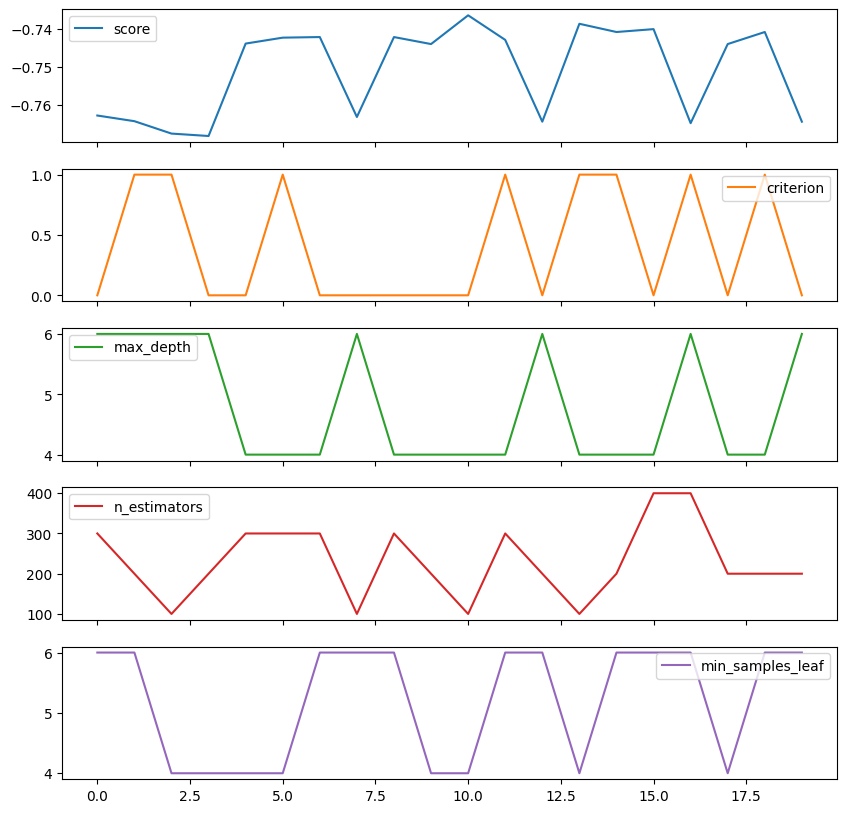

In [40]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['criterion'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0],
                      x['misc']['vals']['min_samples_leaf'][0]] for x in trials_rf.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'criterion', 'max_depth','n_estimators','min_samples_leaf'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

На графике отчетливо видно, что минимальное значение метрики находится чуть дальше отметки 2.5 по оси X. Если провести мысленно вертикальную черту, то на ней окажутся значения следующие:
criterion='entropy',
max_depth=6,
n_estimators=200,
min_samples_leaf=4
Что и выдала программа

### 4.1 Подбор лучших гиперпараметров с помощью OPTUNA для LogisticRegression

In [41]:
def optuna_lg(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l1','l2'])
  solver = trial.suggest_categorical('solver', ['liblinear','saga'])
  C= trial.suggest_float('C', low=0,high=1)
  # создаем модель
  model = LogisticRegression(penalty=penalty,
                            solver=solver,
                            C=C,
                            max_iter=200,
                            random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))
  return score

In [42]:
import optuna
%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_lr = optuna.create_study(study_name="LinearRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_lr.optimize(optuna_lg, n_trials=20)

[I 2024-09-09 13:10:57,845] A new study created in memory with name: LinearRegression


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-09-09 13:11:27,886] Trial 0 finished with value: 0.8507371007371007 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.48397166798977775}. Best is trial 0 with value: 0.8507371007371007.
[I 2024-09-09 13:11:28,456] Trial 1 finished with value: 0.8681217337841992 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.3142628171413814}. Best is trial 1 with value: 0.8681217337841992.
[I 2024-09-09 13:11:29,015] Trial 2 finished with value: 0.8750769230769231 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.48029073933110533}. Best is trial 2 with value: 0.8750769230769231.
/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-09-09 13

И так время обучения модели по оптимизации равно 3 минуты 8 секунд. Достаточно неплоха, по сравнению Hyperopt, посмотрим на качество.

На обучающей выборке модель показала высокий результат.

In [43]:
# выводим результаты на обучающей выборке
print(study_lr.best_params) # Наилучшие значения гиперпараметров 
print(study_lr.best_value) #"f1_score на обучающем наборе

{'penalty': 'l2', 'solver': 'liblinear', 'C': 0.8795115415000342}
0.8849830403946962


In [44]:
# рассчитаем точность для тестовой выборки
model = LogisticRegression(**study_lr.best_params,random_state=42,max_iter=200 )
model.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.3f}".format(model.score(X_test,y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test,y_test_pred)))

accuracy на тестовом наборе: 0.751
f1_score на тестовом наборе: 0.787


Результат действительно у всех моделей более менее схож. Вопрос только в том, как дальше будут использоваться данные модели, либо вариации добавляться либо разово.

Сформируем график, где мы увидим, растет ли наша метрика с увеличением итераций.Для начало проверим, можем ли мы воспользоваться данным инструменом.

In [45]:
optuna.visualization.is_available()

True

Все отлично, визуализируем зависимость метрики от количества итераций.

In [46]:
optuna.visualization.plot_optimization_history(study_lr, target_name="f1_score")

<img src=Optuna_lr.png width=1450px height=30%>

Видим, что наша метрика на тренировочных данных действительно растет.

Далее рассмотрим важность гиперпараметов и посмотрим так же в каких значениях метрика максимальная.

In [47]:
optuna.visualization.plot_param_importances(study_lr, target_name="f1_score")

<img src=param_importances_Optuna_lr.png width=1450px height=30%>

Самым важным параметром оказался C.Это штраф за переобучение модели.

In [48]:
optuna.visualization.plot_contour(study_lr, params=["C", "penalty"],
                                  target_name="f1_score")

<img src=contour_Optuna_lr.png width=1450px height=30%>

А вот значения самих параметров С чуть меньше 0.2, ранее в моделях наблюдалось повышение данного параметра, тут видим наоборот и penalty l1. Примерно такие же данные показала программа оптимизации HyperOpt. 

### 4.2 Подбор лучших гиперпараметров с помощью OPTUNA для RandomForest

In [49]:

def optuna_rf(trial):
    n_estimators=trial.suggest_int('n_estimators',low=100,high=400)
    criterion=trial.suggest_categorical('criterion', ['entropy','gini'])
    max_depth=trial.suggest_int('max_depth',low=3,high=10)
    min_samples_leaf=trial.suggest_int('min_samples_leaf',low=3,high=10)

    model_R=RandomForestClassifier(n_estimators=n_estimators,  
                                               criterion=criterion,
                                               max_depth=max_depth,
                                               min_samples_leaf=min_samples_leaf,
                                               random_state=42)
    model_R.fit(X_train,y_train)
    predict_X=model_R.predict(X_train)
    score=metrics.f1_score(y_train,predict_X)
    return score
    

In [50]:
import optuna
%time
study_random=optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study_random.optimize(optuna_rf,n_trials=20)

[I 2024-09-09 13:14:09,217] A new study created in memory with name: RandomForestClassifier


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


[I 2024-09-09 13:14:12,388] Trial 0 finished with value: 0.8812814070351759 and parameters: {'n_estimators': 227, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8812814070351759.
[I 2024-09-09 13:14:13,278] Trial 1 finished with value: 0.7707006369426752 and parameters: {'n_estimators': 125, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8812814070351759.
[I 2024-09-09 13:14:15,145] Trial 2 finished with value: 0.8709576138147567 and parameters: {'n_estimators': 160, 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8812814070351759.
[I 2024-09-09 13:14:18,667] Trial 3 finished with value: 0.8951486697965572 and parameters: {'n_estimators': 274, 'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8951486697965572.
[I 2024-09-09 13:14:22,484] Trial 4 finished with value: 0.8986232790988736 and parameters: {'n_estimator

Оптимизация optuna показывает отличное время если модель RandomForest. Время обучения составило чуть меньше минуты. 

In [51]:
# выводим результаты на обучающей выборке
print(study_random.best_params) # Наилучшие значения гиперпараметров 
print(study_random.best_value) #"f1_score на обучающем наборе

{'n_estimators': 247, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 3}
0.9231730168644597


In [52]:
# рассчитаем точность для тестовой выборки
model_rf = RandomForestClassifier(**study_random.best_params,random_state=42)
model_rf.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.3f}".format(model_rf.score(X_test,y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test,y_test_pred)))

accuracy на тестовом наборе: 0.802
f1_score на тестовом наборе: 0.787


In [53]:
optuna.visualization.plot_optimization_history(study_random, target_name="f1_score")

<img src=optimization_history_rf_Optuna.png width=1450px height=30%>

По графику так же видим, что при увеличении итераций наша метрика растет.

In [54]:
optuna.visualization.plot_ccccccccccc(study_random, target_name="f1_score")

<img src=param_importances_Optuna_rf.png width=1450px height=30%>

Максимальная зависимость от гиперпараметра max_depth

In [59]:
optuna.visualization.plot_contour(study_random, params=["n_estimators", "max_depth"],
                                  target_name="f1_score")

<img src=contour_Optuna_rf.png width=1450px height=30%>

Так же на контурной карте видим, что максимальные значения достигаются при n_estimators=250 и max_depth=10

Вывод: Все модели имеют право на жизнь и на активное использование, т.к. достигают одиннаковые метрики. Вопрос только во временных рамках, но для удобства и с визуализацией отлично подойдет optuna. Так же она берет не те числа, которые мы сами вписываем или тот шаг, а рандомные, что может улучшить качество модели. Так же можно по визуализации понять, какие гиперпараметры модели более важные.

<img src=table.png width=1450px height=30%>